# CS146 LBA

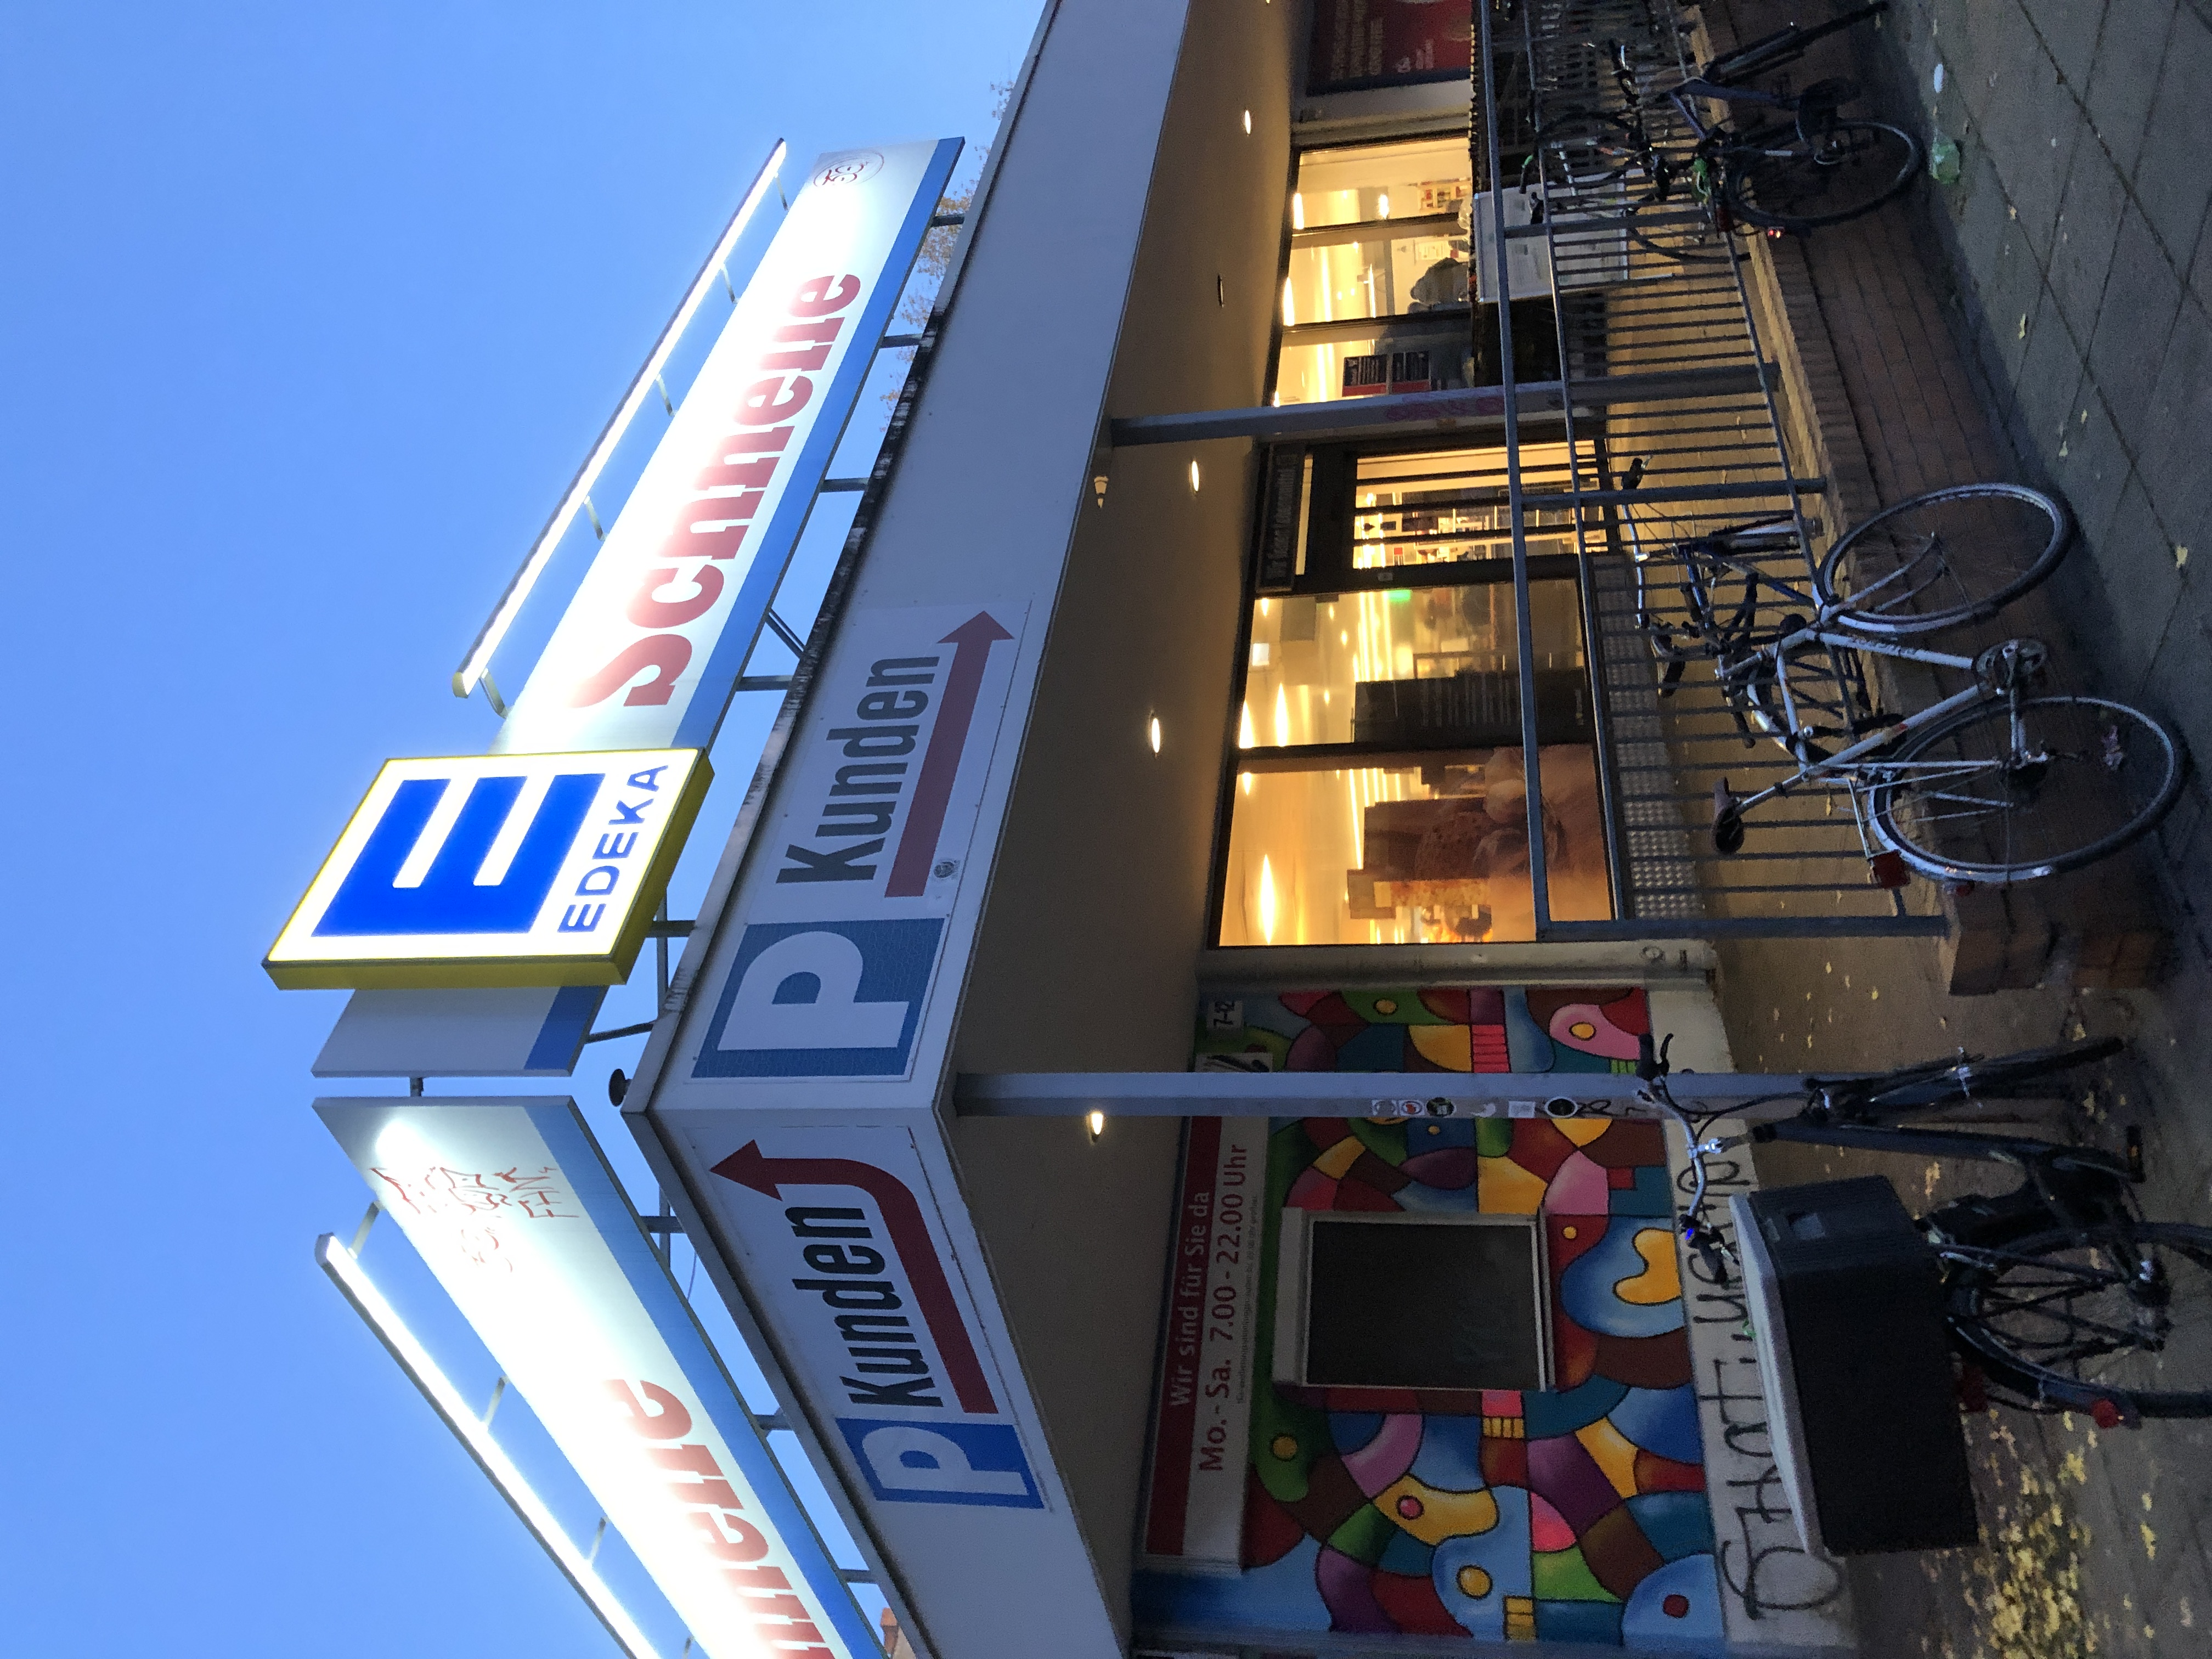

In [0]:
from IPython.display import Image
Image(filename='IMG_7027.JPG') 
Image(filename='IMG_7025.JPG') 

Import libraries

In [0]:
import pystan
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts

Read data

In [0]:
data = pd.read_csv("CS146 LBA data gathering (Fall 2019) (Responses) - Form Responses 1.csv",header = 1)
data.drop(0,inplace=True)

I clean all the data that are not from London and Berlin, mostly because the sample size for their brands are too small (only 1 or 2). Also, I clean the string formation for brands.

In [0]:
data.drop([13,16,17,18,27],inplace=True)
data['Grocery store'] = data['Grocery store'].replace({'Sainsbury':'Sainsbury\'s', 'Tesco':'Tesco Express',
                                                       'Waitrose & Partners Islington':'Waitrose & Partners',
                                                       'Waitrose':'Waitrose & Partners',
                                                       'SAINSBURY\'S':'Sainsbury\'s'})

Then, group price for the products.

In [0]:
products = ['Apple','Banana','Tomato','Potato','Flour','Rice','Milk','Butter','Egg','Chicken']
product_data={}

for i in range(5,60,6):
    product_data[products[int((i+1)/6-1)]] = data.iloc[:,i:i+6]

In [0]:
price_by_product = {}

Scale every product to the same unit (euro/kg, euro/litre or euro/count).

In [0]:
for product, price in product_data.items():
    price['Unit Price 1'] = price.iloc[:,1] / price.iloc[:,0]
    price['Unit Price 2'] = price.iloc[:,3] / price.iloc[:,2]
    price['Unit Price 3'] = price.iloc[:,5] / price.iloc[:,4]
    price.drop(price.columns[[0,1,2,3,4,5]],axis=1,inplace=True)

    #Add correponding data to the dictionary for products
    x = price.to_numpy().flatten()
    x = x[~np.isnan(x)]
    price_by_product[product] = x

    price['Store'] = data['Grocery store']
    price['Location'] = data['Grocery store street address']

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


### Model for products

Set prior for each product based on my knowledge.

In [0]:
prior_for_product = {'Apple':2,'Banana':2,'Tomato':2,'Potato':2,'Flour':1,'Rice':3,'Milk':1.5,'Butter':5,'Egg':0.2,'Chicken':6}

Model code. The model is a simple normal distribution with inverse-gamma prior.

In [0]:
code = """

data {
    int<lower=0> num_data;
    real<lower=0> price[num_data];  // number of recorded unit prices
    real mu;  // mean of x
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
    real<lower=0> nu; // fixed prior hyperparameter
}

parameters {
    real<lower=0> x;  
    real sigma2;
}

model {
    sigma2 ~ inv_gamma(alpha,beta);
    x ~ normal(mu, sqrt(sigma2/nu));
    for (i in 1:num_data){
        price[i] ~ normal(x,sigma2); // likelihood function
    }
}

"""

In [0]:
model = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3805f1329561bbfa362265131f2efdc NOW.


Run the model for each product, using their respective prior and data.

In [0]:
results_base_price = {}

for product, price in price_by_product.items():
    data_for_base_price = {
    'num_data': len(price),
    'price': price,
    'mu': prior_for_product[product],
    'alpha': 0.5,
    'beta': 1,
    'nu': 0.1,
    }   
    result = model.sampling(data=data_for_base_price)
    results_base_price[product] = result

Print all the results and sample 10 posterior pdfs. Here I also record the mean of posterior base price for each product for future use.

Result of Apple :
Inference for Stan model: anon_model_a3805f1329561bbfa362265131f2efdc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        2.73  2.3e-3   0.13   2.47   2.99   3063    1.0
sigma2   2.06  1.7e-3   0.09   1.89   2.25   3030    1.0

Samples were drawn using NUTS at Tue Nov 12 23:07:21 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).



Result of Banana :
Inference for Stan model: anon_model_a3805f1329561bbfa362265131f2efdc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        2.02  6.0e-3   0.33   1.36   2.67   3096    1.0
sigma2   4.99  4.5e-3   0.24   4.54   5.51   2879    1.0

Samples were dra

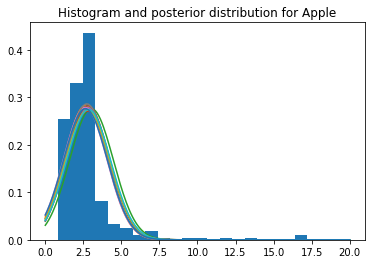

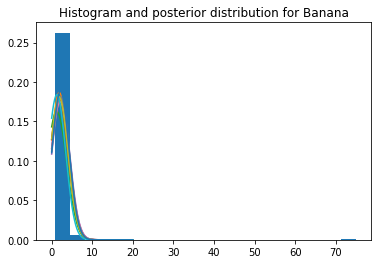

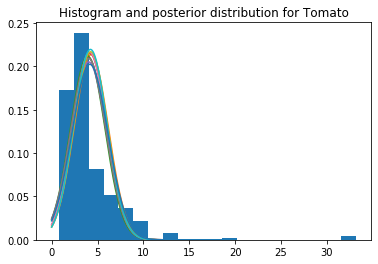

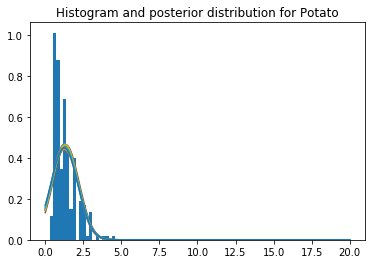

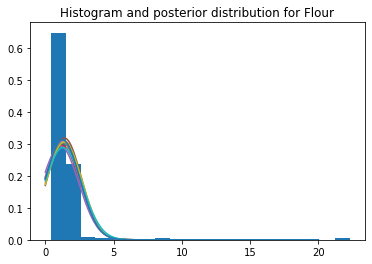

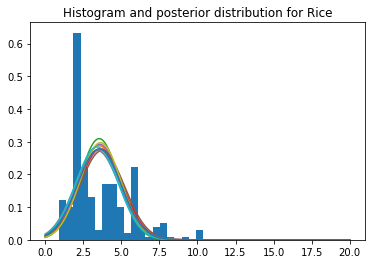

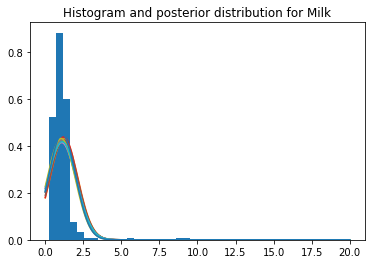

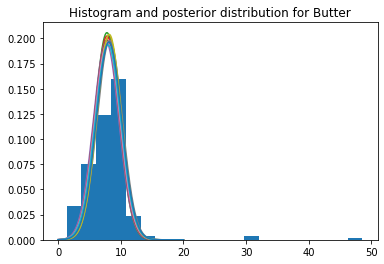

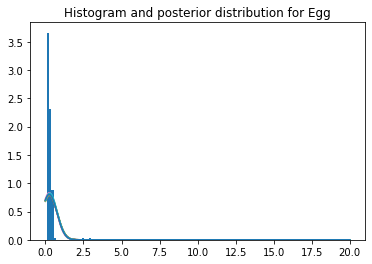

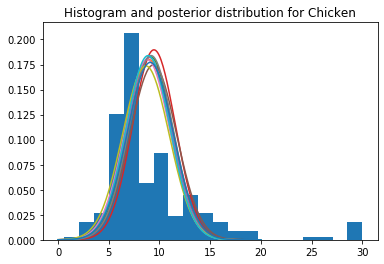

In [0]:
base_price_mean={}

for product, inference in results_base_price.items():
    print('Result of', product,':')
    print(inference.stansummary(pars=['x','sigma2'], probs=[0.025, 0.975]))

    # Extract samples from the posterior
    samples = inference.extract()
    random_sample = np.random.randint(0,4000,size=10)
    mean_sample = [samples['x'][i] for i in random_sample]
    variance_sample = [samples['sigma2'][i] for i in random_sample]

    base_price_mean[product] = np.mean(samples['x'])

    # Plot data histogram and posterior pdf
    plt.figure()
    plt.hist(price_by_product[product],bins=20,density=True)
    for i in range(10):
        plot_x = np.linspace(0,20,200)
        plt.plot(plot_x, sts.norm.pdf(plot_x,loc=mean_sample[i],scale=np.sqrt(variance_sample[i])))
        plt.title('Histogram and posterior distribution for %s'%product)

    print('\n'*2)

One thing noticeable in the result is that the price data does not show a normal distribution. We can probably use other more skewed distribution to model the data and it might generate better results.

### Model for the multiplier for store brand

Group data by brands. Here, since I am curious on a multiplier of price, I normalized every price datum with the mean of base price for the product that was calculated above, so that the result would be a scale parameter

In [0]:
brands = []

for product , price in product_data.items():
    for i in range(88):
        normalize = base_price_mean[product]

        brands.append([price.iloc[i,0]/normalize,price.iloc[i,3]])
        brands.append([price.iloc[i,1]/normalize,price.iloc[i,3]])
        brands.append([price.iloc[i,2]/normalize,price.iloc[i,3]])


In [0]:
brands = pd.DataFrame(data = brands,columns=['Price','Brand'])

brand_names = ['ALDI','REWE','EDEKA','Tesco Express','Waitrose & Partners','Lidl','Sainsbury\'s']

price_by_brand = {}

for name in brand_names:
    x = brands[brands['Brand'].str.match(name)]
    x = x['Price'].to_numpy()
    x = x[~np.isnan(x)]
    price_by_brand[name] = x


Run model on each brand.

In [0]:
results_brands = {}

model2 = pystan.StanModel(model_code=code)

for brand, price in price_by_brand.items():
    data_for_brands = {
    'num_data': len(price),
    'price': price,
    'mu': 1,
    'alpha': 0.5,
    'beta': 1,
    'nu': 0.1,
    }   
    result = model2.sampling(data=data_for_brands)
    results_brands[brand] = result

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3805f1329561bbfa362265131f2efdc NOW.


Show the results.

Result of ALDI :
Inference for Stan model: anon_model_a3805f1329561bbfa362265131f2efdc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x         0.8  5.0e-4   0.03   0.74   0.86   3532    1.0
sigma2   0.62  3.7e-4   0.02   0.58   0.67   3429    1.0

Samples were drawn using NUTS at Tue Nov 12 23:08:59 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).



Result of REWE :
Inference for Stan model: anon_model_a3805f1329561bbfa362265131f2efdc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        0.97  8.1e-4   0.05   0.88   1.06   3352    1.0
sigma2   0.93  6.3e-4   0.03   0.87    1.0   2602    1.0

Samples were drawn 

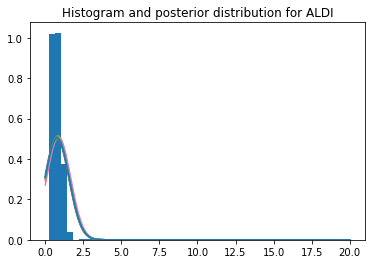

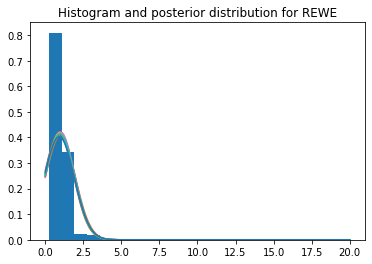

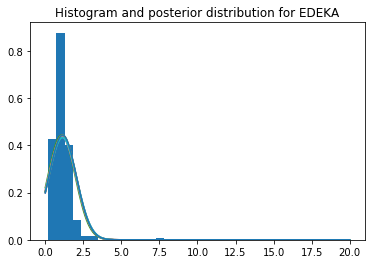

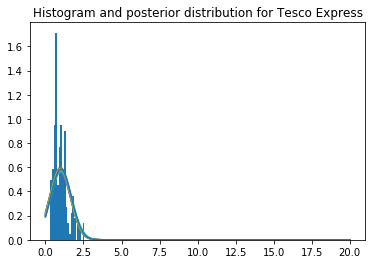

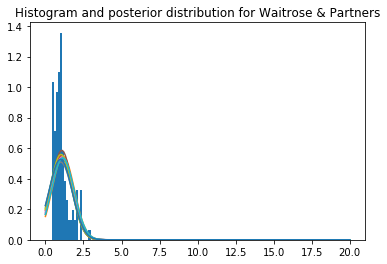

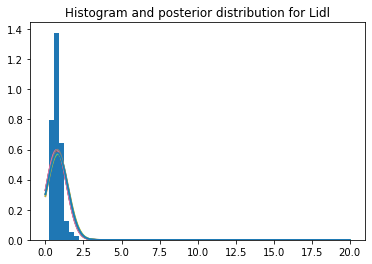

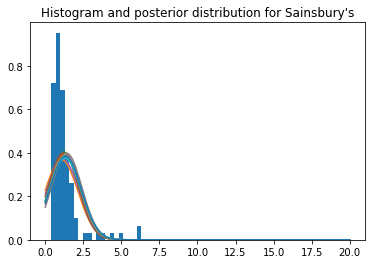

In [0]:
for brand, inference in results_brands.items():
    print('Result of', brand,':')
    print(inference.stansummary(pars=['x','sigma2'], probs=[0.025, 0.975]))

    samples = inference.extract()
    random_sample = np.random.randint(0,4000,size=10)
    mean_sample = [samples['x'][i] for i in random_sample]
    variance_sample = [samples['sigma2'][i] for i in random_sample]


    plt.figure()
    plt.hist(price_by_brand[brand],bins=20,density=True)
    for i in range(10):
        plot_x = np.linspace(0,20,200)
        plt.plot(plot_x, sts.norm.pdf(plot_x,loc=mean_sample[i],scale=np.sqrt(variance_sample[i])))
        plt.title('Histogram and posterior distribution for %s'%brand)

    print('\n'*2)

It turns out that Sainsbury's has the highest multiplier. The location multipliers that are greater than 1 indicate an increase in price (compared with base price) for the brand, and multipliers smaller than 1 indicate a decrease in price.

### Model for location multiplier

I manually searched all the rental price (in euros) of the nearest station/neighborhood for each store in the dataset. The Berlin prices and London prices come from two different data sources, so there is a strong assumption that the prices are calculated through the same measure, which in real life is often impossible. Also, the Berlin prices are mean price for a 70 square meter apartment. To correspond to this assumption, I choose the price for 2 bedroom apartments in London (house size data is unknown). The purpose of using the rental price variable is to conceptually show how different rental price groups correlate with the product price. The data cannot be used for more precise operations, such as predicting product price using regression. The result may be biased because of these assumptions.

|                                    Location                                   | Nearest station rental price (euros) |
|:-----------------------------------------------------------------------------:|:------------------------------------:|
|                             Rummelsburger Str. 98                             |                  774                 |
|                             Karl-Marx-Straße 92-98                            |                  872                 |
|                    Hermannstraße 72, 12049 Berlin, Germany                    |                  820                 |
|                            Lidl, Leipziger Str. 42                            |                 1090                 |
|                          REWE, Landsberger Allee 68D                          |                  734                 |
|                              43-45, Farringdon Rd                             |                 2975                 |
|                          ALDI, Karl-Marx-Straße 92-98                         |                  872                 |
|                            Lidl, Maybachufer 32-33                            |                  924                 |
|        Tesco Express, 122-128 Pentonville Rd, Islington, London N1 9TT        |                 2480                 |
|              Tesco Express, New N Rd, Briton Ferry, London N1 8SY             |                 2480                 |
|                             EDEKA, Grunerstraße 20                            |                  976                 |
|                              168-176, Edgware Rd                              |                 3099                 |
|                 87 Upper Clapton Rd, Cazenove, London, E5 9BU                 |                 1885                 |
|                                2020 Market St.                                |                  NaN                 |
|                             Lidl, Sonnenallee 192                             |                  836                 |
|                            Lidl, Charlottenstraße 2                           |                 1090                 |
|                  645 San Antonio Rd, Mountain View, CA 94040                  |                  NaN                 |
|                    2811 Middlefield Rd, Palo Alto, CA 94306                   |                  NaN                 |
|                             2300 16th St Unit 203                             |                  NaN                 |
|                                Hermannstraße 55                               |                  872                 |
|                         EDEKA, Frankfurter Allee 35-37                        |                  863                 |
|                        ALDI Berlin kreuzberg Straße 39                        |                  844                 |
|                              Eisenbahnstrasse 42                              |                  941                 |
|                   Prenzlauer Allee 44, 10405 Berlin, Germany                  |                 1018                 |
|                    Friedenstraße 94A, 10249 Berlin, Germany                   |                  877                 |
|                     Rigaer Str. 44, 10247 Berlin, Germany                     |                  863                 |
|       Cherry Tree Walk Centre, Whitecross St, Barbican, London EC1Y 8NX"      |                 2191                 |
|                            Lotte Mart Seoul Station                           |                  NaN                 |
|                    Chausseestraße 43, 10115 Berlin, Germany                   |                  886                 |
|                 EDEKA Thaut, Jessnerstraße 47-55, 10247 Berlin                |                  809                 |
|                  Greifswalder Str. 33a, 10405 Berlin, Germany                 |                  893                 |
|                    Wrangelstraße 53, 10997 Berlin, Germany                    |                  955                 |
|                        Kiefholzstraße 50, 12435 Berlin                        |                  794                 |
|                                 Annenstraße 4A                                |                 1128                 |
|                              Karl-Marx-Straße 231                             |                  812                 |
|                             Frankfurter Allee 117                             |                  863                 |
|                               Kiefholzstraße 49                               |                  794                 |
|                             Landsberger Allee 277                             |                  691                 |
|                                  100 East Rd.                                 |                 2480                 |
|                            REWE, Skalitzer Str. 134                           |                  865                 |
|                 Edeka Fiebig, Kottbusser Damm 80, 10967 Berlin                |                  924                 |
|                    The Brunswick Centre, 23-39 Handel Str.                    |                 2455                 |
|                           REWE, Invalidenstraße 158                           |                  893                 |
|                                Luisenstraße 52                                |                  932                 |
|                        ALDI, Josef-Orlopp-Straße 22-24                        |                  863                 |
|                              ALDI, Hauptstraße 36                             |                  804                 |
|                      Lidl, Glasower Str. 42, 12051 Berlin                     |                  820                 |
|                  Rewe City, Friedrichstraße 60, 10117 Berlin                  |                 1090                 |
|        Sainsbury's, 15-17 Tottenham Court Rd, Fitzrovia, London W1T 1BJ       |                 2913                 |
|           Sainsbury's, 31-41 Liverpool Rd, The Angel, London N1 0RW           |                 2480                 |
|                             EDEKA, Wittenbergpl. 4                            |                  916                 |
|                               Kiefholzstraße 386                              |                  794                 |
|                   EDEKA Siebert, Hasenheide 57, 10967 Berlin                  |                  924                 |
|                           EDEKA, Pannierstr. 37 - 38                          |                  924                 |
|                          REWE, Frankfurter Allee 144                          |                  863                 |
|                             Stresemannstraße 72-78                            |                  826                 |
|                              Heidelberger Str. 90                             |                  794                 |
|                             REWE, Bartningallee 3                             |                  957                 |
|                               Invalidenstraße 59                              |                  932                 |
|                           EDEKA, Ritterstraße 38-40                           |                  854                 |
| Waitrose & Partners Crouch End, 35-39 The Broadway, Crouch End, London N8 8DU |                 1785                 |
|            Tesco Express, 1-23 City Rd, Shoreditch, London EC1Y 1AG           |                 2975                 |
|                      Frankfurter Allee 212, 10365 Berlin                      |                  863                 |
|                           ALDI, Hoeppnerstraße 3-13                           |                  755                 |
|                          Litfaß-Platz 4, 10178 Berlin                         |                 1002                 |
|                         Lidl, Heinrich-Heine-Straße 30                        |                  842                 |
|                             Frankfurter Allee 105                             |                  863                 |
|                              Nollendorfplatz 8-9                              |                  879                 |
|                 40 New Kent Rd, London SE1 6TJ, United Kingdom                |                 2157                 |
|                     Herrfurthpl. 12, 12049 Berlin, Germany                    |                  820                 |
|                    REWE, Potsdamer Straße 128, 10783 Berlin                   |                  801                 |
|                  31-41 Liverpool Rd, The Angel, London N1 0RW                 |                 2480                 |
|                  14-16 St Martin's Le Grand, London EC2V 6BJ                  |                 3099                 |
|                            EDEKA, Andreasstraße 59                            |                  877                 |
|                             Budapester Str. 38-50                             |                  859                 |
|                          EDEKA, Straßburger Str. 9a-b                         |                  942                 |
|              Sainsbury's, 38 Stratton St, Mayfair, London W1J 8LT             |                 4760                 |
|                             Kaiser-Wilhelm-Platz 2                            |                  884                 |
|                                Fischerinsel 12                                |                 1128                 |
|                           EDEKA, Eckertstraße 7 - 11                          |                  877                 |
|                    231-232 Strand, Temple, London WC2R 1DA                    |                 2975                 |
|                   21 Liverpool Rd, The Angel, London N1 9EN                   |                 2480                 |
|    Tesco Express, 1 Brewhouse Yard, St John St, Farringdon, London EC1V 4JD   |                 2975                 |
|                131 Aldersgate St, Barbican, London EC1A 4JQ, UK               |                 3099                 |
|                         REWE, Schönhauser Allee 36-39                         |                 1018                 |
|                          ALDI, Frankfurter Allee 144                          |                  863                 |
|                            ALDI, Gerichtstraße 2-3                            |                  741                 |
|                            Lidl, Zeughofstraße 23 A                           |                  955                 |
|                                Berolinastraße 7                               |                  976                 |
|                                 Yorckstraße 78                                |                  908                 |
|                     EDEKA, Platz der Vereinten Nationen 14                    |                  976                 |
|                       Friedrichstraße 100, 10117 Berlin                       |                 1044                 |
|                        Kreuzbergstraße 40, 10965 Berlin                       |                  844                 |

Input the rental price data

In [0]:
rental_price = [774,872,820,1090,734,2975,872,924,2480,2480,976,3099,1885,836,1090,872,863,844,941,1018,877,863,2191,886,
809,893,955,794,1128,812,863,794,691,2480,865,924,2455,893,932,863,804,820,1090,2913,2480,916,794,924,924,863,826,794,
957,932,854,1785,2975,863,755,1002,842,863,879,2157,820,801,2480,3099,877,859,942,4760,884,1128,877,2975,2480,2975,
3099,1018,863,741,955,976,908,976,1044,844]

In [0]:
rental = []

for product , price in product_data.items():
    for i in range(88):
        normalize = base_price_mean[product]

        rental.append([price.iloc[i,0]/normalize,rental_price[i]])
        rental.append([price.iloc[i,1]/normalize,rental_price[i]])
        rental.append([price.iloc[i,2]/normalize,rental_price[i]])

I tried to group the rental price using quantiles. However, since some London prices are extremely high, and other rental prices are grouped around 800, I would get a very wide 75%-100% range and a very narrow 0%-75% range (1100 to 4760 versus 691 to 1100). Therefore, I used a more arbitrary way. This way ensures that there are enough data in each group at the expense of less generalize-ability due to the wide range in the upper quantile.

In [0]:
rental = pd.DataFrame(data = rental,columns=['Price','Rent'])

rental['Price Group'] = pd.qcut(rental['Rent'],q=4,labels=['Low','Medium','High','Very High'])

In [0]:
rental_group = ['Low','Medium','High','Very High']

price_by_rent = {}

for group in rental_group:
    x = rental[rental['Price Group'].str.match(group)]
    x = x['Price'].to_numpy()
    x = x[~np.isnan(x)]
    price_by_rent[group] = x

In [0]:
results_rent = {}

model3 = pystan.StanModel(model_code=code)
prior_for_location = {'Low':0.8,'Medium':1,'High':1.2,'Very High':1.5}

for group, price in price_by_rent.items():
    data_for_rent = {
    'num_data': len(price),
    'price': price,
    'mu': prior_for_location[group],
    'alpha': 0.5,
    'beta': 1,
    'nu': 0.1,
    }   
    result = model3.sampling(data=data_for_rent)
    results_rent[group] = result

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3805f1329561bbfa362265131f2efdc NOW.


Result of Low rental price:
Inference for Stan model: anon_model_a3805f1329561bbfa362265131f2efdc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        0.88  3.5e-4   0.02   0.84   0.91   3159    1.0
sigma2   0.48  2.6e-4   0.01   0.46   0.51   3060    1.0

Samples were drawn using NUTS at Tue Nov 12 23:10:35 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).



Result of Medium rental price:
Inference for Stan model: anon_model_a3805f1329561bbfa362265131f2efdc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        1.03  7.7e-4   0.05   0.94   1.12   3478    1.0
sigma2   1.12  5.2e-4   0.03   1.06   1.19   3752   

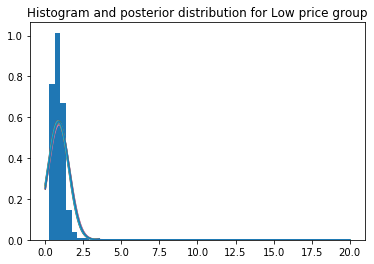

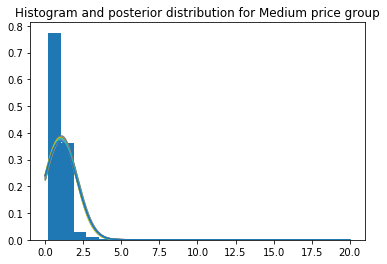

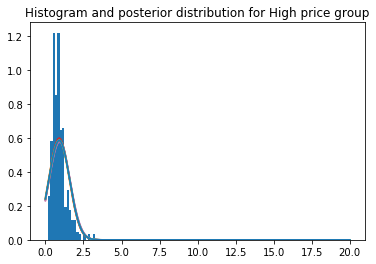

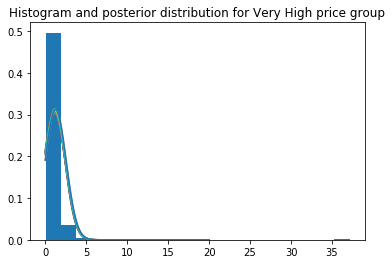

In [0]:
for group, inference in results_rent.items():
    print('Result of',group,'rental price:')
    print(inference.stansummary(pars=['x','sigma2'], probs=[0.025, 0.975]))

    samples = inference.extract()
    random_sample = np.random.randint(0,4000,size=10)
    mean_sample = [samples['x'][i] for i in random_sample]
    variance_sample = [samples['sigma2'][i] for i in random_sample]


    plt.figure()
    plt.hist(price_by_rent[group],bins=20,density=True)
    for i in range(10):
        plot_x = np.linspace(0,20,200)
        plt.plot(plot_x, sts.norm.pdf(plot_x,loc=mean_sample[i],scale=np.sqrt(variance_sample[i])))
        plt.title('Histogram and posterior distribution for %s price group'%group)

    print('\n'*2)

We can see that "very high" rental price group has the highest multiplier and "low" has the lowest. However, the "high" group has a lower posterior multiplier than "low" group. This is probably because the grouping of rental prices is not that precise as suggested above. For a more precise relationship, we can do a regression using the rental prices as an independent variable to see how rental prices affect the pricing of products. To identify a deeper causal relationship, we can also do statistical matching in order to find this relationship. Particularly, we can focus on only Berlin data and find the difference in product price for products selling in the same brand of stores. Another way to improve this is that we should find more reliable and consistent data source for rental prices, instead of using two different datasets that might be built using different measures.